This notebook recreates the famous cryptography paper by Coram and Beineke in which the authors were able to use the Metropolis-Hastings algorithm to crack a simple "substitution cipher" used to encrypt messages. A substitution cipher is just a function that translates each letter of the coded message to one letter of the alphabet. To decode the messages, they initialized a random substitution cipher. At each iteration of the algorithm, they propose a new substitution cipher by swapping two letters in code space uniformly at random. This new substitution cipher is then accepted or rejected with a given probability consistent with the normal Metropolis-Hastings algorithm.

In order to use the Metropolis-Hastings algorithm, we need to know how likely each substitution cipher is. First, we need to get a baseline idea of how frequently each letter comes after another. To do this, we downloaded the book War and Peace and recorded exactly that (this results in a matrix of transition probabilities). Once we have this matrix of transition probabilities, we decode the cipher, and then multiply the transition probabilities corresponding to the decoded message together. 

This algorithm allows us to navigate the state space of substitution ciphers efficiently, finding the most likely ciphers given the observed coded message. We write a program to solve substitution ciphers and give an example of a coded and decoded message (a great quote about the power of probability!)

In [2]:
## Stanford MCMC decoding

import numpy as np
import matplotlib.pyplot as plt

## Idea is to first get some sort of prior distribution for how likely characters are to follow each other
## If you are working with a simple substitution cipher i.e. one character = another character, one to one correspondence

# So, need to download some massive text document, and record how likely it is for one character to follow another
# Need program to record the counts and put this into a transition matrix

filepath = 'warAndPeace.txt'

# Define the characters or patterns you want to replace with spaces
charactersToReplace = ['"', "'", '--', '!', '@', '#', '$', '%', '^', '&', '*', '(', ')', \
    '-', '_', '=', '+', '[', ']', '{', '}', ';', ':', ',', '.', '/', '?', '<', '>', '|', \
        '\n', '\t', 'à', 'ä', 'é', 'ê']

with open(filepath, 'r') as file:

    text = file.read().lower()
    text = ''.join(' ' if char in charactersToReplace else char for char in text) # Replace characters with spaces using a generator expression
    text = ''.join(char for char in text if not char.isdigit())

textArray = np.array(list(text))
uniqueCharacters = np.unique(textArray)

# Now that we have removed all of the unwanted characters from the text, we can count the transitions

epsilon = .00001
transitionMatrix = np.zeros([len(uniqueCharacters), len(uniqueCharacters)]) + epsilon
numCharacters = 3000000

for charIndex in range(numCharacters):

    currentChar = text[charIndex]
    nextChar = text[charIndex + 1]
    tempTransitionRow = np.where(currentChar == uniqueCharacters)
    tempTransitionCol = np.where(nextChar == uniqueCharacters)
    transitionMatrix[tempTransitionRow, tempTransitionCol] += 1

# Normalizing

for iiRow in range(np.shape(transitionMatrix)[0]):

    transitionMatrix[iiRow, :] = transitionMatrix[iiRow, :] / np.sum(transitionMatrix[iiRow, :])


In [3]:
## Now that we have the transition matrix, we can calculate the plausibility/likelihood of each coded text
# First create a simple substitution cipher

import random
import numpy as np
import sys 

alphabet = ' abcdefghijklmnopqrstuvwxyz'

def makeRandomKey():

    tempList = list(alphabet)
    random.shuffle(tempList)
    randomKey = dict(zip(alphabet, tempList))

    return randomKey

filepath = 'dice_fair_success.txt'
with open(filepath, 'r') as file:

    textString = file.read().lower()
    textString = ''.join(' ' if char in charactersToReplace else char for char in textString) # Replace characters with spaces using a generator expression
    textString = ''.join(char for char in textString if not char.isdigit())

cipherKey = makeRandomKey()

# Use the cipher on the string
cipher = []

for charIndex in range(len(textString)):

    currentChar = textString[charIndex]
    tempTargetChar = cipherKey[currentChar]
    cipher.append(tempTargetChar)

cipher = ''.join(cipher)

## Using your deciphering method for a known cipher

numChars = len(cipher)
decodedCipher = []

for jjChar in range(numChars):

    tempChar = cipher[jjChar]
    tempDecodedLetter = [key for key, value in cipherKey.items() if value == tempChar][0]
    decodedCipher.append(tempDecodedLetter[0])

decodedCipher = ''.join(decodedCipher)
print('Coded message: ', cipher)
print(decodedCipher)
machineEpsilon = sys.float_info.epsilon


eukmvkmvbxdvbnvlyvnrpbhkedvatbedmvrfbtevohbfrfk keyvvknvwbzvurmvlrzdveudvgbh zvrvodhndsevldsurxkmlvvudvurmvrev drmevsbxsdzdzvmbvltsuvebvbthvklodhndsevkxed  dsemveurevkxvbhzdhvebvohdzksev kee dvorhemvbnvkevvvgdvxddzvxbevmb pdvkxxtldhrf dvzknndhdxekr vdatrekbxmvvftevsrxvtmdvzksdvgkeuvnrkhvmtssdmmvv
this is one of my favorite quotes about probability  if god has made the world a perfect mechanism  he has at least conceded so much to our imperfect intellects that in order to predict little parts of it   we need not solve innumerable differential equations  but can use dice with fair success  


In [9]:
def proposeNewKey(key):

    pair = random.sample(alphabet, 2)
    newKey = dict(key)
    newKey[pair[0]] = key[pair[1]]
    newKey[pair[1]] = key[pair[0]]

    return newKey

In [5]:
## Now you can use the algorithm to start decoding

numIterations = 50000
numChars = len(cipher)
codeSpace = makeRandomKey()
accept = np.zeros([numIterations])
acceptanceProbabilities = np.zeros([numIterations])
plausibility = np.zeros([numIterations])

for iiIteration in range(numIterations):

    tempTransitionProbs = np.zeros([numChars - 1, 1])

    for jjChar in range(numChars - 1):

        currentChar = cipher[jjChar]
        nextChar = cipher[jjChar + 1]
        rowIndex = np.where(uniqueCharacters == [key for key, value in codeSpace.items() if value == currentChar])[0][0]
        columnIndex = np.where(uniqueCharacters == [key for key, value in codeSpace.items() if value == nextChar])[0][0]
        tempTransitionProbs[jjChar] = transitionMatrix[rowIndex, columnIndex]

    for jjProb in range(np.size(tempTransitionProbs)):

        if tempTransitionProbs[jjProb] < machineEpsilon:

            tempTransitionProbs[jjProb] = machineEpsilon

    currentPlausibility = np.sum(np.log(tempTransitionProbs))
    plausibility[iiIteration] = currentPlausibility

    candidateCodeSpace = proposeNewKey(codeSpace)
    candidateTransitionProbs = np.zeros([numChars - 1, 1])

    for jjChar in range(numChars - 1):

        currentChar = cipher[jjChar]
        nextChar = cipher[jjChar + 1]
        rowIndex = np.where(uniqueCharacters == [key for key, value in candidateCodeSpace.items() if value == currentChar])[0][0]
        columnIndex = np.where(uniqueCharacters == [key for key, value in candidateCodeSpace.items() if value == nextChar])[0][0]
        candidateTransitionProbs[jjChar] = transitionMatrix[rowIndex, columnIndex]

    for jjProb in range(np.size(tempTransitionProbs)):

        if candidateTransitionProbs[jjProb] < machineEpsilon:

            candidateTransitionProbs[jjProb] = machineEpsilon

    candidatePlausibility = np.sum(np.log(candidateTransitionProbs))
    logDifference = candidatePlausibility - currentPlausibility
    
    if logDifference >= 0:

        acceptanceProb = 1

    else:

        acceptanceProb = np.exp(logDifference)

    u = np.random.uniform()
    acceptanceProbabilities[iiIteration] = acceptanceProb

    if u < acceptanceProb:

        accept[iiIteration] = 1
        codeSpace = candidateCodeSpace

    # Decode the message

    if np.mod(iiIteration, 5000) == 0:

        mcmcdecodedCipher = []

        for jjChar in range(numChars):

            tempChar = cipher[jjChar]
            tempDecodedLetter = [key for key, value in codeSpace.items() if value == tempChar][0]
            mcmcdecodedCipher.append(tempDecodedLetter[0])

        mcmcdecodedCipher = ''.join(mcmcdecodedCipher)
        print(mcmcdecodedCipher)




orxtlxtlduwld lsvl fqdzxowlmedowtlfkdeolazdkfkxixovllx lhdnlrftlsfnwlorwlydzinlflawz wpolswprfuxtsllrwlrftlfoliwftolpdupwnwnltdlseprlodldezlxsawz wpolxuowiiwpotlorfolxuldznwzlodlazwnxpolixooiwlafzotld lxolllywluwwnludoltdiqwlxuueswzfkiwlnx  wzwuoxfilwmefoxdutllkeolpfuletwlnxpwlyxorl fxzlteppwttll
this is one om py mavorite quotes about frobability  im god has pade the world a fermect pechanisp  he has at least conceded so puch to our ipfermect intellects that in order to fredict little farts om it   we need not solve innuperable dimmerential equations  but can use dice with mair success  
this is one of my favorite quotes apout bropapility  if jod has made the world a berfect mechanism  he has at least conceded so much to our imberfect intellects that in order to bredict little barts of it   we need not solve innumeraple differential equations  put can use dice with fair success  
this is one of my fakorite quotes about probability  if jod has made the world a perfect mechanism  he has

In [8]:
numChars = len(cipher)
knowndecodedCipher = []

for jjChar in range(numChars):

    tempChar = cipher[jjChar]
    tempDecodedLetter = [key for key, value in cipherKey.items() if value == tempChar][0]
    knowndecodedCipher.append(tempDecodedLetter[0])

knowndecodedCipher = ''.join(knowndecodedCipher)

print('Decoded with MCMC: ', mcmcdecodedCipher)
print('Known decoded message: ', knowndecodedCipher)

Decoded with MCMC:  this is one of my favorite quotes about probability  if god has made the world a perfect mechanism  he has at least conceded so much to our imperfect intellects that in order to predict little parts of it   we need not solve innumerable differential equations  but can use dice with fair success  
Known decoded message:  this is one of my favorite quotes about probability  if god has made the world a perfect mechanism  he has at least conceded so much to our imperfect intellects that in order to predict little parts of it   we need not solve innumerable differential equations  but can use dice with fair success  


We can see that the MCMC method has perfectly decoded the substitution cipher. We plot the likelihood of the current decoding function across iterations of the algorithm. The likelihood makes some large jumps at the start of the algorithm but then only makes minor changes to the decoding key. The decoded messages printed during the algorithm reflect this above. 

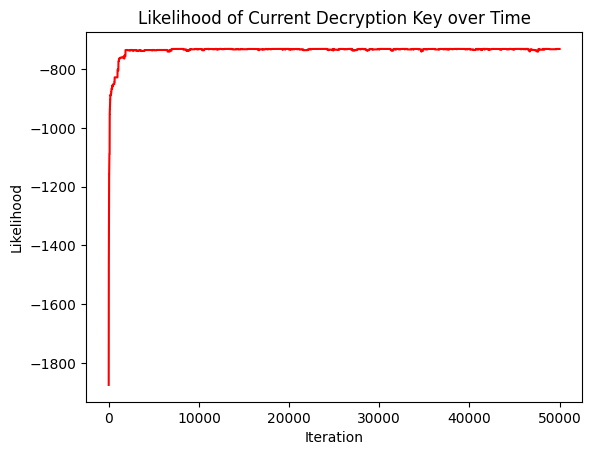

In [7]:
# Plausibility 

plt.plot(list(range(numIterations)), plausibility, color = 'r')
plt.xlabel('Iteration')
plt.ylabel('Likelihood')
plt.title('Likelihood of Current Decryption Key over Time')
plt.show()